In [13]:
# Core 
import datetime
import os
import glob

# HDF4 Support
from pyhdf.SD import SD, SDC

# Analysis 
import xarray as xr
import numpy as np
import pyproj as pp
import scipy as sp
import transect_analysis as ta

# Plotting 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as mticker
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors

# Debugging 
import pdb
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [14]:
# Specify start and end coords on coast.
# Choose order so that (transect_axis, coastline_axis) forms a right hand coordinate system
lon0 = 134.5293 
lat0 = -12.4715
coast_lon1 = 133.3290
coast_lat1 = -12.1468

trans_lon0, trans_lat0, trans_lon1, trans_lat1, n_points, n_trans, coast_distances, tran_distances = ta.define_transects(
    lon0, lat0, coast_lon1, coast_lat1, 453300
)

In [31]:
month = '11'

TRMM_tran = xr.open_dataset(
    '/g/data/w40/esh563/goulburn_NT/transect_means/TRMM_3B42_goulburn_2005-2014_{}.nc'.format(month)
)
# TRMM_tran = TRMM_tran
TRMM_tran.precipitation.attrs['units'] = 'mm/h'

WRF_PRCP_tran = xr.open_dataset('/g/data/w40/esh563/goulburn_NT/transect_means/PRCP_goulburn_12.nc')
WRF_PRCP_tran = WRF_PRCP_tran * 1000
WRF_PRCP_tran.RAINNC.attrs['units'] = 'mm/h'

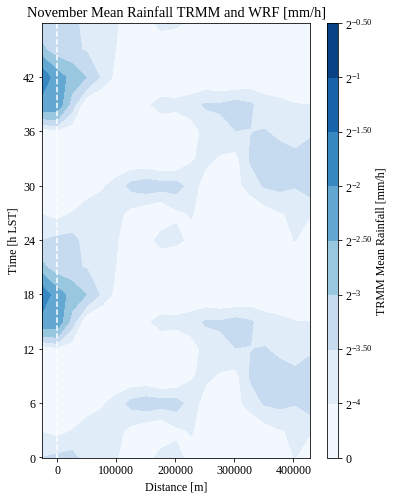

In [32]:
fig, ax = plt.subplots(figsize=(6,8))

# Initialise fonts
rcParams['font.family'] = 'serif'
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'font.size': 12})
rcParams.update({'mathtext.fontset' : 'dejavuserif'})

# Define LST
lon_mean = np.mean(np.concatenate((trans_lon0, trans_lon1)))
LST_hov = (np.arange(-24,48) + (lon_mean / 360) * 24)
LST_hov_TRMM = (np.arange(-24,48,3) + (lon_mean / 360) * 24)
hov_shading = np.concatenate([TRMM_tran.precipitation.values]*3, axis=0)
hov_contours = np.concatenate([WRF_PRCP_tran.RAINNC.values]*3, axis=0)

LST_hov = LST_hov[15:48+15]
LST_hov_TRMM = LST_hov_TRMM[5:16+6]
hov_shading = hov_shading[5:16+6,:]
hov_contours = hov_contours[15:48+15,:]

plt.plot(
    [0, 0], [LST_hov[0], LST_hov[-1]+1],
    '--', color='white')

levels = np.array([0, 2**-4, 2**-3.5, 2**-3, 2**-2.5, 2**-2, 2**-1.5, 2**-1, 2**-0.5])

locator = mticker.SymmetricalLogLocator(base=2, linthresh=2**-4)
locator = locator.set_params(numticks = np.size(levels))
formatter = mticker.LogFormatterMathtext(base=2)

contour_TRMM = plt.contourf(
    TRMM_tran.transect_axis.values,
    LST_hov_TRMM,
    hov_shading, 
    levels = levels,
    cmap = 'Blues',
    norm=colors.SymLogNorm(vmin=0, vmax=2**-0.5, linthresh=2**-4.0, linscale=2**-4.0)
)

cbar_TRMM=plt.colorbar(
    contour_TRMM, orientation='vertical', aspect=40,
    ticks=locator, format=formatter,
)
cbar_TRMM.set_label('TRMM Mean Rainfall [mm/h]')

# contour_WRF_PRCP = plt.contour(
#     WRF_PRCP_tran.transect_axis.values[3:],
#     LST_hov,
#     hov_contours[:,3:], 
#     levels = np.array([2**-2, 2**-1]),
#     colors = ['red', 'red'],
#     linestyles = ['dashed', 'solid'],
#     linewidths = 0.75,
# )

# contour_WRF_PRCP.collections[0].set_dashes([(0, (5.0, 2.0))])

# labels = ['$2^{' + str(i) + '}$ mm/h' for i in range(-2, 0)] 
# for i in range(len(labels)):
#     contour_WRF_PRCP.collections[i].set_label(labels[i])
# plt.legend(
#     loc='lower center', bbox_to_anchor=(0.5, -0.225), ncol=2, 
#     frameon=True, title = 'WRF Mean Rainfall [mm/h]'
# )

plt.title(
    'November Mean Rainfall TRMM and WRF [mm/h]'
)
plt.xlabel('Distance [m]')
plt.ylabel('Time [h LST]')

plt.yticks(np.arange(0, 48, step=6))

plt.savefig('/g/data/w40/esh563/goulburn_NT/figures/TRMM_{}.png'.format(month), bbox_inches='tight')